In [ ]:
import torch
import os
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from albumentations import HorizontalFlip, Normalize, Compose
from albumentations.pytorch import ToTensorV2
from skimage import io, transform

In [ ]:
Device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Hyperparameters
NUM_EPOCHS = 15
BATCH_SIZE = 15
LEARNING_RATE = 1e-3
BEST_MODEL_PATH = './best_model.pt'
CHECKPOINT_PATH = './checkpoint'
DATASET = './dataset/'

DOWNLOAD DATASET

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/stage1_train.zip' -d './dataset'

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: ./dataset/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/160cf18b03df69978e2ed33335afcd781ebebf4ee42df566aaa6fd0aee66ac93.png  
  inflating: ./dataset/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/16d3bf2426e9cda0e4f435de3a0c260d17be460f1c834c1282dfd68f9fcf7509.png  
  inflating: ./dataset/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1cfe69ef1dec8963e05ba8386a956af0073ba0bec2cc8ba534df81ef6dee905a.png  
  inflating: ./dataset/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1d2543cd2a8134ac2ca091a230bd15270826f8dd83c6594550b7f0fc85a15f8e.png  
  inflating: ./dataset/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/24b50e6e3406e513d47ddfa9bd85505a95a266858cffc730a9ad7bc99936b800.png  
  inflating: ./dataset/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/341193ff7f035f118eabe9

LOAD DATASET

In [ ]:
def get_transforms(mean, std):
    transforms_list = []
    transforms_list.extend([HorizontalFlip(p=0.5)])
    transforms_list.extend([Normalize(mean=mean, std=std, p=1),
                            ToTensorV2()])
    transform_list_composed = Compose(transforms_list)
    return transform_list_composed

class Nuclie(Dataset):
    def __init__(self, path):
        self.path = path
        self.folders = os.listdir(path)
        self.transforms = get_transforms(0.5, 0.5)

    def __len__(self):
        return len(self.folders)
    
    def __getitem__(self, idx):
        image_folder = os.path.join(self.path, self.folders[idx], 'images/')
        mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')
        image_path = os.path.join(image_folder, os.listdir(image_folder)[0])

        image = io.imread(image_path)[:, :, :3].astype('float32')
        image = transform.resize(image, (128, 128))

        mask = self.get_mask(mask_folder, 128, 128).astype('float32')

        data_transformed = self.transforms(image=image, mask=mask)
        image = data_transformed['image']
        mask = data_transformed['mask']
        mask = mask.permute(2, 0, 1)

        return (image, mask)

    def get_mask(self, mask_folder, IMAGE_HEIGHT, IMAGE_WIDTH):
        mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=bool)
        for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder, mask_))
            mask_ = transform.resize(mask_, (IMAGE_HEIGHT, IMAGE_WIDTH))
            mask_ = np.expand_dims(mask_, axis=-1)
            mask = np.maximum(mask, mask_)
        return mask

In [ ]:
base_dir = './dataset'
dataset = Nuclie(base_dir)
dataset.__len__()
dataset.__getitem__(0)

(tensor([[[-0.9540, -0.9515, -0.9548,  ..., -0.9564, -0.9568, -0.9553],
          [-0.9526, -0.9538, -0.9537,  ..., -0.9558, -0.9542, -0.9543],
          [-0.9525, -0.9533, -0.9511,  ..., -0.9566, -0.9541, -0.9532],
          ...,
          [-0.9498, -0.9521, -0.9512,  ..., -0.9413, -0.9442, -0.9420],
          [-0.9513, -0.9515, -0.9528,  ..., -0.9459, -0.9456, -0.9468],
          [-0.9534, -0.9509, -0.9526,  ..., -0.9494, -0.9484, -0.9517]],
 
         [[-0.9540, -0.9515, -0.9548,  ..., -0.9564, -0.9568, -0.9553],
          [-0.9526, -0.9538, -0.9537,  ..., -0.9558, -0.9542, -0.9543],
          [-0.9525, -0.9533, -0.9511,  ..., -0.9566, -0.9541, -0.9532],
          ...,
          [-0.9498, -0.9521, -0.9512,  ..., -0.9413, -0.9442, -0.9420],
          [-0.9513, -0.9515, -0.9528,  ..., -0.9459, -0.9456, -0.9468],
          [-0.9534, -0.9509, -0.9526,  ..., -0.9494, -0.9484, -0.9517]],
 
         [[-0.9540, -0.9515, -0.9548,  ..., -0.9564, -0.9568, -0.9553],
          [-0.9526, -0.9538,

In [ ]:
for image, mask in dataset:
  print(image.shape)
  print(mask.shape)
  break

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


UTILITY

In [ ]:
# converting tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image

# some utility functions
def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    std = np.array((0.5))
    mean = np.array((0.5))
    mask  = std * mask + mean
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

def plot_image(no_):
    iter_ = iter(train_loader)
    images,masks = next(iter_)
    images = images.to(Device)
    masks = masks.to(Device)
    
    plt.figure(figsize=(10,6))
    for idx in range(0,no_):
         image = image_convert(images[idx])
         plt.subplot(2,no_,idx+1)
         plt.title('image')
         plt.imshow(image)
    for idx in range(0,no_):
         mask = mask_convert(masks[idx])
         plt.subplot(2,no_,idx+no_+1)
         plt.title('mask')
         plt.imshow(mask,cmap='gray')

    plt.show()

In [ ]:
#Splitting to trainset and validation set and loading the data with batch size of 15
train_set, val_set = random_split(dataset, [580, 90])
train_loader = DataLoader(dataset=train_set, batch_size=15, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=15)

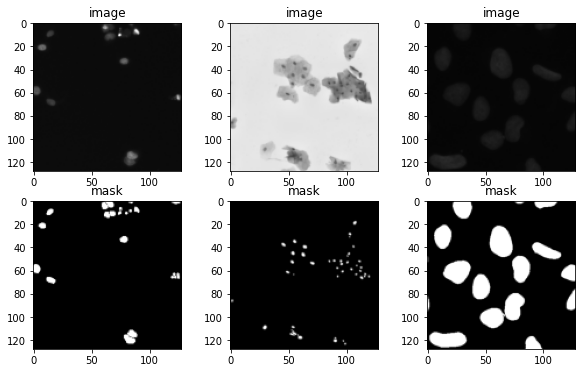

In [ ]:
plot_image(3)

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.conv(x)


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of the UNet
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of the UNet
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Down part path
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Up part path
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = F.pad(x, (0, skip_connection.shape[3] - x.shape[3],
                                          0, skip_connection.shape[2] - x.shape[2]))
            
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        
        return self.final_conv(x)



In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
    
    def forward(self, inputs, targets, smooth=1):
        bce_weight = 0.5
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = 1 - (2. * intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        bce = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss = bce*bce_weight + dice*(1 - bce_weight)
        return loss

def get_iou(y_pred, y, smooth=1):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection
    iou = (intersection + smooth)/(union + smooth)
    return iou

def get_iou_batch(y_pred, y):
    ious = []

    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.clone().cpu().detach().numpy()
    y = y.clone().cpu().detach().numpy()

    for pred, label in zip(y_pred, y):
        ious.append(get_iou(pred, label))

    iou = np.nanmean(ious)
    return iou

In [ ]:
def save_checkpoint(state, is_best, checkpoint_path, best_model_path):
    torch.save(state, checkpoint_path)
    if is_best:
        shutil.copyfile(checkpoint_path, best_model_path)
        
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    val_loss_min = checkpoint['val_loss_min']
    return model, optimizer, checkpoint['epoch'], val_loss_min.item()

TRAIN

In [ ]:
model = UNet().to(Device)
model

UNet(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNor

MODEL TRAINING

In [ ]:
criterion = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
val_loss_min = 3.95275
train_loss, val_loss = [], []
train_iou, val_iou = [], []
for epoch in range(NUM_EPOCHS):
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS}')
    
    start_time = time.time()

    running_train_loss = []
    running_train_score = []
    for image, mask in train_loader:
        image = image.to(Device, dtype=torch.float)
        mask = mask.to(Device, dtype=torch.float)

        # Forward
        mask_pred = model.forward(image)
        loss = criterion(mask_pred, mask)
        score = get_iou_batch(mask_pred, mask)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss.append(loss.item())
        running_train_score.append(score)
    else:
        running_val_loss = []
        running_val_score = []
        with torch.no_grad():
            for image, mask in val_loader:
                image = image.to(Device, dtype=torch.float)
                mask = mask.to(Device, dtype=torch.float)

                # Forward
                mask_pred = model.forward(image)
                loss = criterion(mask_pred, mask)
                score = get_iou_batch(mask_pred, mask)

                running_val_loss.append(loss.item())
                running_val_score.append(score)
    
    epoch_train_loss, epoch_train_score = np.mean(running_train_loss), np.mean(running_train_score)
    print(f'Train loss: {epoch_train_loss}, IoU: {epoch_train_score}')
    train_loss.append(epoch_train_loss)
    train_iou.append(epoch_train_score)

    epoch_val_loss, epoch_val_score = np.mean(running_val_loss), np.mean(running_val_score)
    print(f'Validation loss: {epoch_val_loss}, IoU: {epoch_val_score}')
    val_loss.append(epoch_val_loss)
    val_iou.append(epoch_val_score)

    checkpoint = {
        'epoch': epoch + 1,
        'val_loss_min': val_loss_min,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        }

    save_checkpoint(checkpoint, False, CHECKPOINT_PATH, BEST_MODEL_PATH)

    if epoch_val_loss <= val_loss_min:
      print(f'Validation loss decreased ({val_loss_min:.6f} -> {epoch_val_loss:.6f}). Saving model...')
      save_checkpoint(checkpoint, True, CHECKPOINT_PATH, BEST_MODEL_PATH)
      val_loss_min = epoch_val_loss
    
    time_elapsed = time.time() - start_time
    print(f'{(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')

Epoch: 1/15
Train loss: 0.4470022305464133, IoU: 0.2697348524706606
Validation loss: 0.3065439313650131, IoU: 0.36543051594302384
Validation loss decreased (3.952750 -> 0.306544). Saving model...
4m 47s
Epoch: 2/15
Train loss: 0.2991016388703615, IoU: 0.39229978674083515
Validation loss: 0.2320859730243683, IoU: 0.4713874820180675
Validation loss decreased (0.306544 -> 0.232086). Saving model...
4m 37s
Epoch: 3/15
Train loss: 0.23014652958283058, IoU: 0.4833048717975571
Validation loss: 0.18139839420715967, IoU: 0.5620767476255412
Validation loss decreased (0.232086 -> 0.181398). Saving model...
4m 33s
Epoch: 4/15
Train loss: 0.1970300976282511, IoU: 0.5391712063375472
Validation loss: 0.1748847415049871, IoU: 0.5905675334761952
Validation loss decreased (0.181398 -> 0.174885). Saving model...
4m 34s
Epoch: 5/15
Train loss: 0.19470981451181266, IoU: 0.5674622228189656
Validation loss: 0.17733903725941977, IoU: 0.615000134170444
4m 32s
Epoch: 6/15
Train loss: 0.16669304898151985, IoU: 0

PLOTTING LOSS AND IOU SCORE

In [ ]:
# plt.figure(figsize=(20,10))
# plt.subplot(1,2,1)
# plt.plot(train_loss,label='train_loss')
# plt.plot(val_loss,label='val_loss')
# plt.legend()
# plt.title('Loss Plot')
# plt.subplot(1,2,2)
# plt.plot(train_iou,label='train_iou')
# plt.plot(val_iou,label='val_iou')
# plt.legend()
# plt.title('IOU Plot')
# plt.show()

In [ ]:
model, optimizer, start_epoch, val_loss_min = load_checkpoint(CHECKPOINT_PATH, model, optimizer)

MODEL TEST

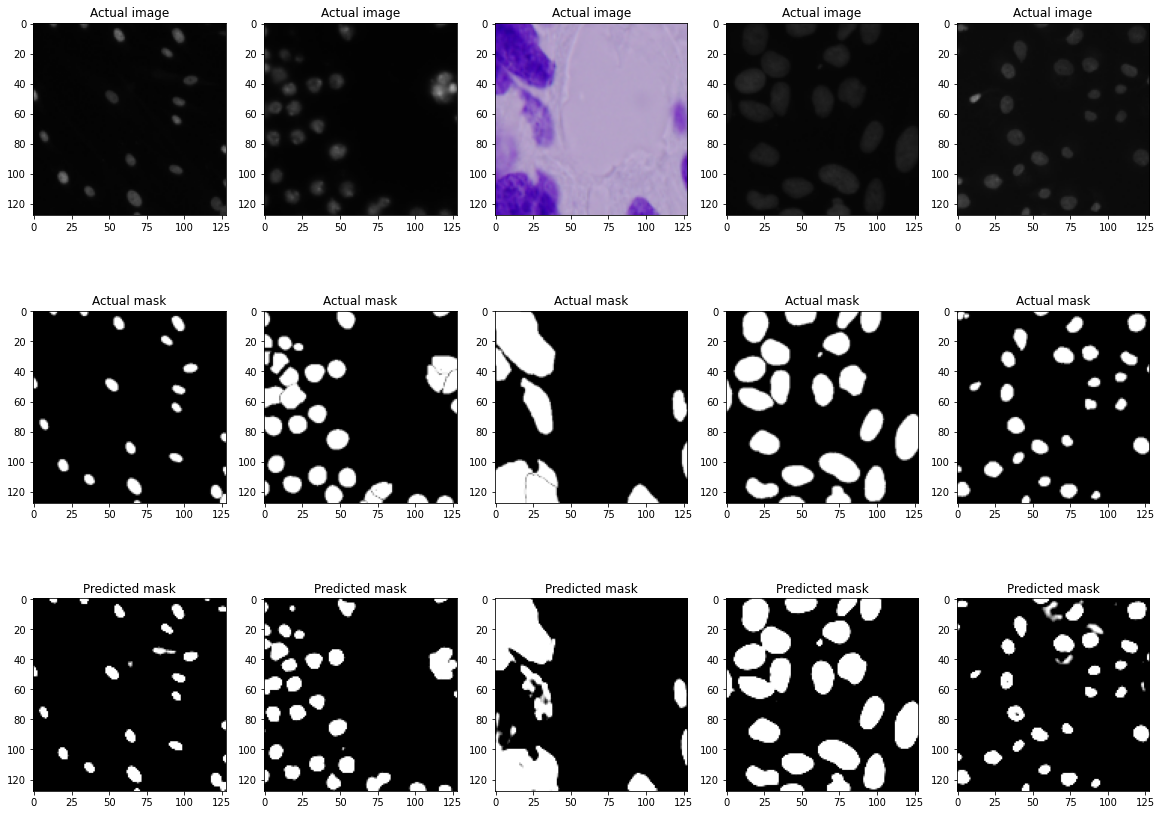

In [ ]:
iter_ = iter(val_loader)
image, mask = next(iter_)
image = image.to(Device,dtype=torch.float)
mask = mask.to(Device,dtype=torch.float)
y_pred = model.forward(image)


plt.figure(figsize=(20,15))
for i in range(0,5):
  plt.subplot(3,5,i+1)
  plt.title('Actual image')
  plt.imshow(image_convert(image[i]))
for i in range(0,5):
  plt.subplot(3,5,i+5+1)
  plt.title('Actual mask')
  plt.imshow(mask_convert(mask[i]),cmap='gray')
for i in range(0,5):
  plt.subplot(3,5,i+10+1)
  plt.title('Predicted mask')
  plt.imshow(mask_convert(y_pred[i]),cmap='gray')
plt.show()